In [211]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fpath ='C:/chan/remote_sensing/'
fname ='GK2B_GOCI2_L2_20231120_011530_LA_SSC.nc'
fdata = fpath + fname
fdata = nc.Dataset(fdata)
fdata

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6 ACDD-1.3
    acknowledgement: 
    comment: 
    creator_email: kosc@kiost.ac.kr
    creator_name: KOSC
    creator_url: http://kosc.kiost.ac.kr
    earth_radius: 6378137.0
    false_easting: 0.0
    false_northing: 0.0
    geographic_crs_name: WGS 84
    geospatial_lat_resolution: 250 meters
    geospatial_lat_units: degree_north
    geospatial_lon_resolution: 250 meters
    geospatial_lon_units: degree_east
    grid_mapping_name: geostationary
    history: input:CHL_first,CHL_search,STATIC__output:SSC
    horizontal_datum_name: WGS 1984
    institution: KIOST, Korea Ocean Satellite Center
    instrument: GOCI-II
    keywords: 
    keywords_vocabulary: 
    latitude_of_projection_origin: 0.0
    license: 
    longitude_of_projection_origin: 128.2
    naming_authority: kr.ac.kiost.kosc
    nominal_satellite_height: 42164000.0
    number_of_total_bands: 12
    observation_end_ti

In [212]:
geo_data = fdata.groups['geophysical_data']
print(list(geo_data.variables))
nav_data = fdata.groups['navigation_data']
print(list(nav_data.variables))

['SSC_direction', 'flag', 'SSC_speed', 'SSC_u', 'SSC_v']
['latitude', 'longitude']


In [213]:
ssc_direction = geo_data.variables['SSC_direction'][:]
lons = nav_data.variables['longitude'][:]
lats = nav_data.variables['latitude'][:]
print(lons.shape, lats.shape)

(8000, 10500) (8000, 10500)


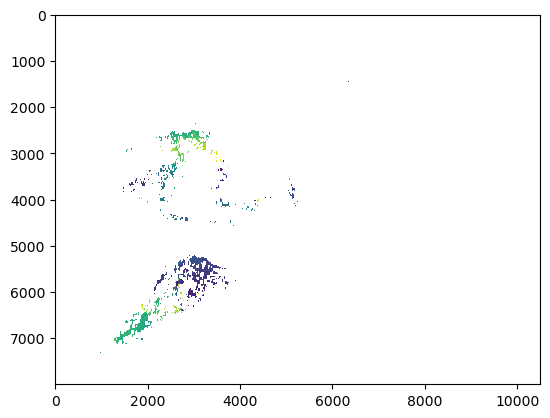

In [214]:
import matplotlib.pyplot as plt
plt.imshow(ssc_direction)

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


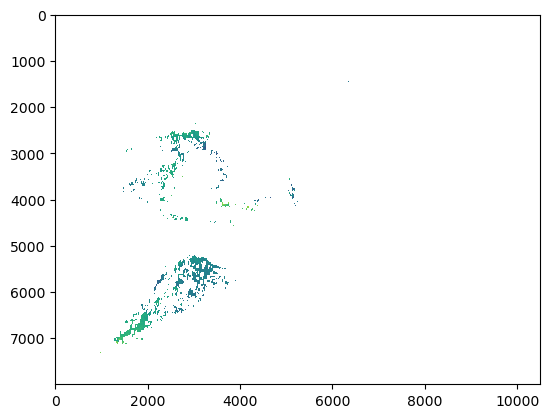

In [215]:
ssc_u = geo_data.variables['SSC_u'][:]
ssc_v = geo_data.variables['SSC_v'][:]
print(ssc_u)
plt.imshow(ssc_u)

In [216]:
#순서
# 1. (8000.10500)
# 2. TFTF 공간 만들기
# 3. lons, lats 대입
# 4. quiver

In [217]:
min_lon, max_lon = 120, 135
min_lat, max_lat = 25, 43

In [218]:
mask = (lons >= min_lon) & (lons <= max_lon) & (lats >= min_lat) & (lats <= max_lat)
mask.shape

(8000, 10500)

In [219]:
ssc_u = geo_data.variables['SSC_u'][:]
ssc_v = geo_data.variables['SSC_v'][:]


# mask한 부분의 값만 True.
ssc_u_filtered = np.where(mask, ssc_u, np.nan)
ssc_v_filtered = np.where(mask, ssc_v, np.nan)
lons = np.where(mask, lons, np.nan)
lats = np.where(mask, lats, np.nan)

# 해류 속도계산
current_speed = np.sqrt(ssc_u**2 + ssc_v**2)

C:\Users\김채은\AppData\Local\Temp\ipykernel_13296\2846345731.py:12: RuntimeWarning: invalid value encountered in sqrt
  current_speed = np.sqrt(ssc_u**2 + ssc_v**2)


In [220]:
# 데이터 안몰리게 각 배열에서 매 120번째가 선택되도록
density_factor = 100
ssc_u_reduced = ssc_u_filtered[::density_factor, ::density_factor]
ssc_v_reduced = ssc_v_filtered[::density_factor, ::density_factor]
lons_reduced = lons[::density_factor, ::density_factor]
lats_reduced = lats[::density_factor, ::density_factor]
current_speed_reduced = current_speed[::density_factor, ::density_factor]
ssc_direction= ssc_direction[::density_factor, ::density_factor]

# 속도에 임계깞 주기
# magnitude_threshold = 
# current_speed_reduced = current_speed_reduced< magnitude_threshold

In [221]:
lons.shape

(8000, 10500)

In [222]:
print(current_speed.shape)
print(current_speed_reduced.shape)

(8000, 10500)
(80, 105)


### direction 사용했을때

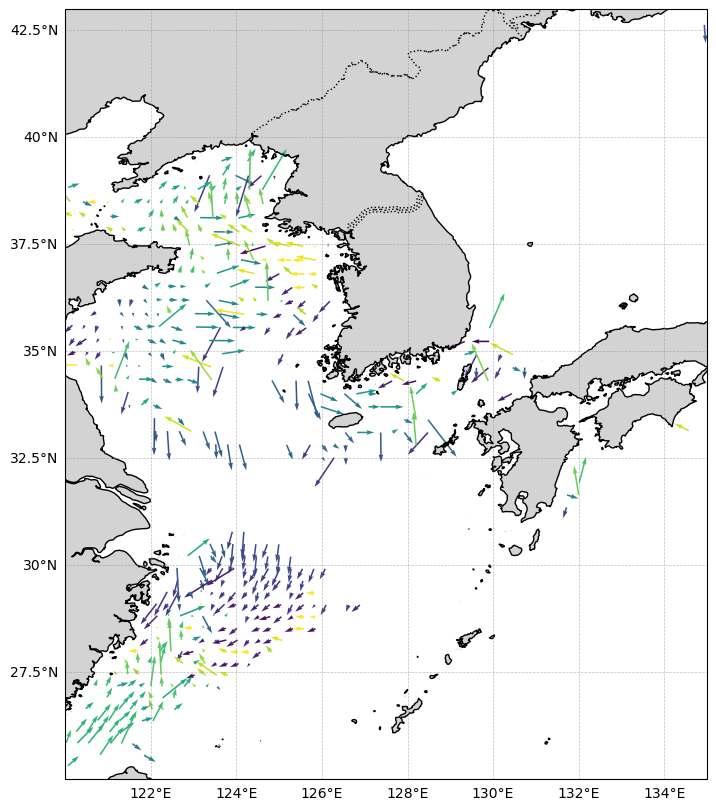

In [223]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

q = ax.quiver(lons_reduced, lats_reduced, ssc_u_reduced, ssc_v_reduced,ssc_direction,
              scale=8, transform=ccrs.PlateCarree())

plt.show()

### current_speed = np.sqrt(ssc_u_filtered**2 +ssc_v_filtered**2) 계산 사용했을 때

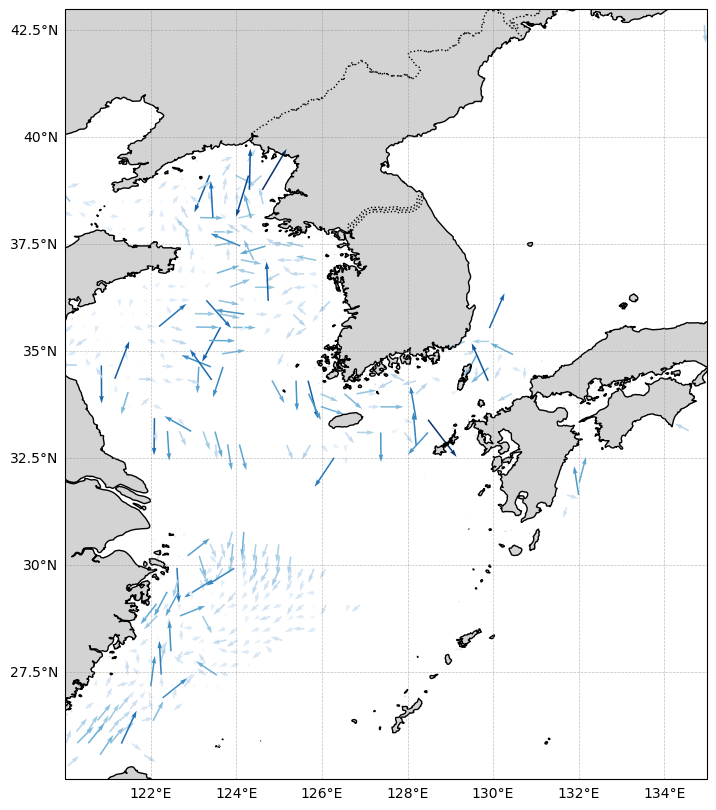

In [224]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

q = ax.quiver(lons_reduced, lats_reduced, ssc_u_reduced, ssc_v_reduced,
               current_speed_reduced, scale=8, cmap='Blues', transform=ccrs.PlateCarree());
plt.show()